In [1]:
import os
import config

from scipy import stats

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid')

In [2]:
# Define necessary directory paths for reference text and scores, obtain the file count.

data_name = "T50_T50"
data_path = "decode_" + data_name
log_name = os.path.join(config.log_root, data_path)

ref_dir = os.path.join(log_name, "rouge_ref")
dec_dir = os.path.join(log_name, "rouge_dec_dir")
scores_dir = os.path.join(log_name, "rouge_scores")

file_count = len(os.listdir(ref_dir))

In [3]:
# Obtain the score values for ROUGE1 from csv files.
df = pd.read_csv(os.path.join(scores_dir, 'rouge_1.csv'), usecols=['F1', 'Precision', 'Recall'])

In [4]:
# Get lengths from decoded and reference texts.
dec_lengths = []
ref_lengths = []
context_lengths = []
for i in range(len(os.listdir(ref_dir))):
    dec_file = os.path.join(dec_dir, str(i).zfill(6) + '_decoded.txt')
    ref_file = os.path.join(ref_dir, str(i).zfill(6) + '_reference.txt')

    with open(dec_file) as f:
        dec_lengths.append(len(f.read().split()))

    with open(ref_file) as f:
        ref_lengths.append(len(f.read().split()))

    context_dir = '../finished_files/data_T50/input_tokenized_dir/index_'+str(i)+'.txt'
    with open(context_dir) as f:
        context_lengths.append(len(f.readline().split()))


df['dec_lengths'] = dec_lengths
df['ref_lengths'] = ref_lengths
df['context_lengths'] = context_lengths

df['ref_context_ratio'] = abs(df['context_lengths']-df['ref_lengths'])/df['context_lengths']
df['dec_context_ratio'] = abs(df['context_lengths']-df['dec_lengths'])/df['context_lengths']
df['ref_dec_ratio'] = abs(df['dec_lengths']-df['ref_lengths'])/df['ref_lengths']

df

,F1,Recall,Precision,dec_lengths,ref_lengths,context_lengths,ref_context_ratio,dec_context_ratio,ref_dec_ratio
0,0.746269,0.595238,1.000000,35,63,267,0.764045,0.868914,0.444444
1,0.235294,0.266667,0.210526,43,36,817,0.955936,0.947368,0.194444
2,0.410256,1.000000,0.258065,38,12,302,0.960265,0.874172,2.166667
3,0.192308,0.188679,0.196078,73,72,551,0.869328,0.867514,0.013889
4,0.412698,0.866667,0.270833,59,17,786,0.978372,0.924936,2.470588
...,...,...,...,...,...,...,...,...,...
999,0.218750,0.148936,0.411765,39,71,433,0.836028,0.909931,0.450704
1000,0.185185,0.250000,0.147059,41,21,547,0.961609,0.925046,0.952381
1001,0.391304,1.000000,0.243243,44,10,555,0.981982,0.920721,3.400000
1002,0.725664,0.594203,0.931818,60,115,590,0.805085,0.898305,0.478261


In [5]:
df.describe()

,F1,Recall,Precision,dec_lengths,ref_lengths,context_lengths,ref_context_ratio,dec_context_ratio,ref_dec_ratio
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.435035,0.509465,0.449850,53.885458,56.850598,540.903386,0.870569,0.874004,1.051909
std,0.284220,0.338090,0.313518,17.270005,55.470844,239.892444,0.143331,0.089103,1.459745
min,0.000000,0.000000,0.000000,35.000000,5.000000,117.000000,0.005435,0.307692,0.000000
25%,0.190226,0.206897,0.183588,41.000000,23.000000,365.750000,0.842308,0.851279,0.281250
50%,0.353890,0.388861,0.358732,48.000000,38.000000,523.000000,0.921007,0.901193,0.578024
75%,0.682250,0.901190,0.705882,62.250000,71.250000,675.000000,0.958007,0.929286,1.226667
max,1.000000,1.000000,1.000000,100.000000,692.000000,1819.000000,0.993225,0.978567,15.200000


In [6]:
# Remove outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

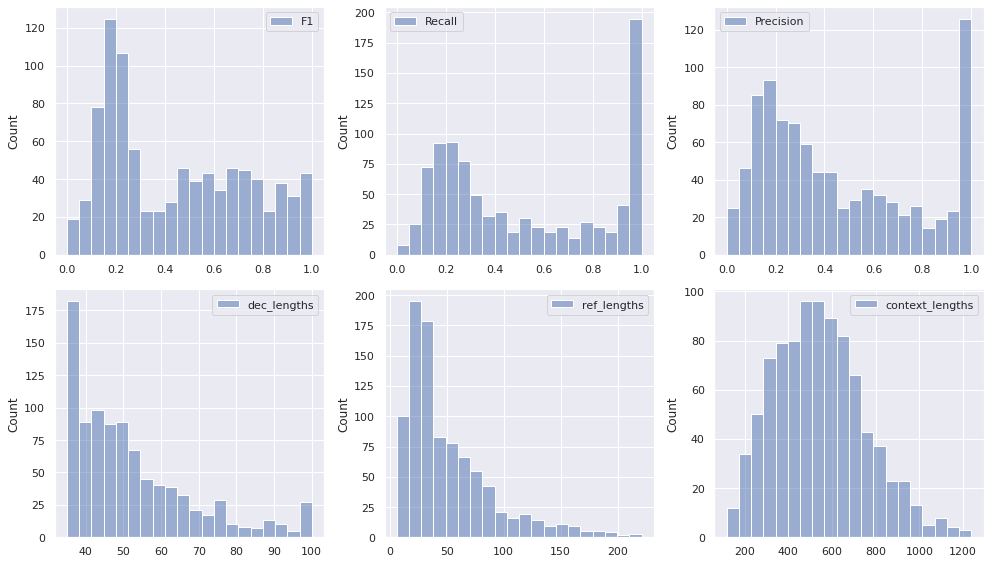

In [7]:
# Distributions of ROUGE scores and token length.

fig, ax = plt.subplots(2, 3, figsize=(14, 8))
col=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        sns.histplot(df.iloc[:, [col]], ax= ax[j, i], bins=20)
        col+=1
fig.tight_layout()
fig.show()


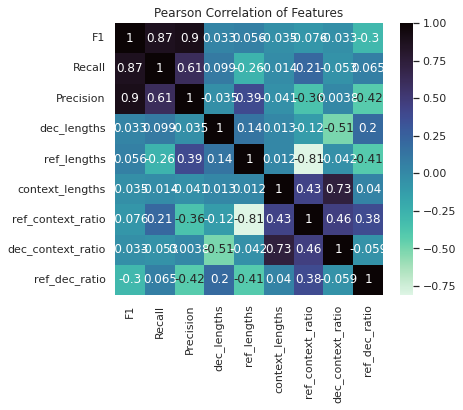

In [8]:
plt.figure(figsize=(6,5))
plt.title('Pearson Correlation of Features')
sns.heatmap(df.corr(), cmap = 'mako_r', annot = True)
plt.show()

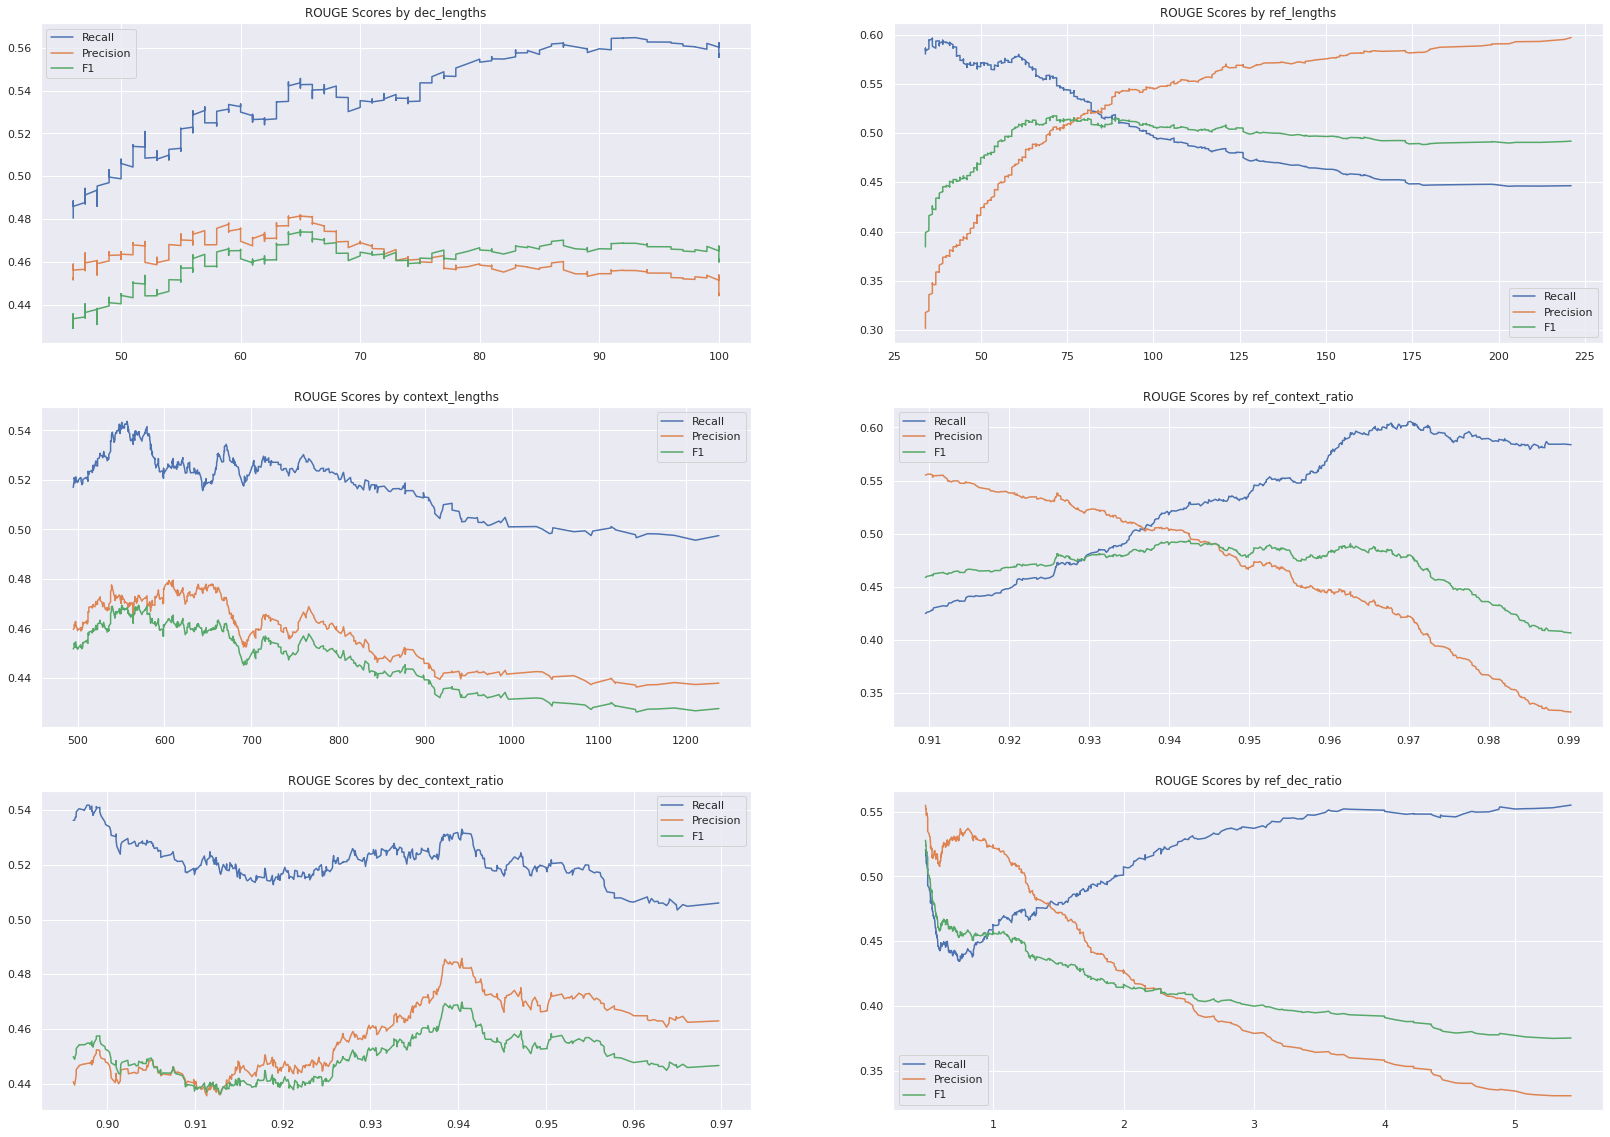

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(28, 20))
columns=['dec_lengths', 'ref_lengths', 'context_lengths', 'ref_context_ratio', 'dec_context_ratio', 'ref_dec_ratio']
col_index = 0
for x in range(3):
    for y in range(2):
        for y_column in ['Recall', 'Precision', 'F1']:
            

            x_column = columns[col_index]
            df_sorted = df.sort_values(by=x_column)

            X = df_sorted[x_column]
            Y = df_sorted[y_column].rolling(window=400).mean()

            
            ax[x,y].plot(X, Y, label=y_column)
            ax[x,y].set_title('ROUGE Scores by {x_column}'.format(x_column=x_column, y_column=y_column))
            ax[x, y].legend()
        col_index += 1
        

plt.show()

In [10]:
df.to_csv('../logs/rouge_evaluation/rouge_scores_legth_comparison.csv', index=False)

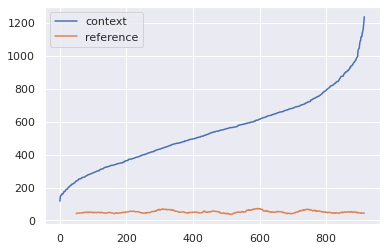

In [11]:
df_sorted = df.sort_values(by='context_lengths')
plt.plot(range(df.shape[0]),df_sorted['context_lengths'], label='context')
plt.plot(range(df.shape[0]), df_sorted['ref_lengths'].rolling(window=50).mean(), label='reference')
plt.legend()
plt.show()